# Import Libraries

In [1]:
from sched import scheduler
!pip install gpytorch torchsummary iterative-stratification optuna pytorch_metric_learning wandb
!pip install torch pydicom pandas scikit-learn scikit-image numpy opencv-python matplotlib

In [2]:
import optuna
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from pytorch_metric_learning import losses

from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, \
    multilabel_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

import sys

sys.path.append('../')

import models.mil_resnet as MILModels
from utils import hard_negative_mining as hnm
import gpytorch
from layers.gaussian_process import SingletaskGPModel, PGLikelihood
from utils.early_stopping import EarlyStoppingForOptimization, EarlyStopping

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import gc

torch.cuda.empty_cache()
gc.collect()

/home/hskha23/miniconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


55

In [3]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Configurations
## GPU Configurations

In [4]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: NVIDIA GeForce RTX 4070 SUPER is available.
cuda


In [5]:
%load_ext autoreload
%autoreload 2

## Seed Everything

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

## Constants and Hyperparameters

In [7]:
import yaml

with open("../config.yaml") as file:
    config = yaml.safe_load(file)

# Accessing constants from config
HEIGHT = config['height']
WIDTH = config['width']
CHANNELS = config['channels']

TRAIN_BATCH_SIZE = config['train_batch_size']
VALID_BATCH_SIZE = config['valid_batch_size']
TEST_BATCH_SIZE = config['test_batch_size']
TEST_SIZE = config['test_size']
VALID_SIZE = config['valid_size']

TRAINING_TYPE = config['training_type']
DATA_REDUNDANCY = config['data_redundancy']
GP_MODEL = config['gp_model']
GP_KERNEL = config['kernel_type']
MODEL_TYPE = config['model_type']
CONTRASTIVE_LEARNING = config['contrastive_learning']

MAX_SLICES = config['max_slices']
SHAPE = tuple(config['shape'])

NUM_EPOCHS = config['num_epochs']
LEARNING_RATE = config['learning_rate']
LEARNING_RATE_NGD = config['learning_rate_ngd']
INDUCING_POINTS = config['inducing_points']
THRESHOLD = config['threshold']
POS_WEIGHT = config['pos_weight']

NUM_CLASSES = config['num_classes']

TARGET_LABELS = config['target_labels']

MODEL_PATH = config['model_path']
LIKELIHOOD_PATH = config['likelihood_path']
DEVICE = config['device']

PROJECTION_LOCATION = config['projection_location']
PROJECTION_HIDDEN_DIM = config['projection_hidden_dim']
PROJECTION_OUTPUT_DIM = config['projection_output_dim']

ATTENTION_HIDDEN_DIM = config['attention_hidden_dim']

In [8]:
KAGGLE = os.path.exists(('kaggle/input'))
REMOTE_SERVER = os.path.exists(('/workspace/rsna-ich-mil'))
ROOT_DIR = None

if KAGGLE:
    DATA_DIR = ROOT_DIR + 'rsna-mil-training/'
    DICOM_DIR = DATA_DIR
    CSV_PATH = DICOM_DIR + 'training_1000_scan_subset.csv'
elif REMOTE_SERVER:
    DATA_DIR = '/root/rsna-ich-mil/'
    DICOM_DIR = DATA_DIR
    if DATA_REDUNDANCY:
        CSV_PATH = DATA_DIR + 'training_dataset_1150_redundancy.csv'
    else:
        CSV_PATH = '/workspace/training_dataset_1150.csv'
    print('Running on remote server.')
else:
    DATA_DIR = '../rsna-ich-mil/'
    DICOM_DIR = DATA_DIR
    if DATA_REDUNDANCY:
        CSV_PATH = './data_analyze/training_dataset_3_redundancy.csv'
    else:
        CSV_PATH = './data_analyze/training_dataset_3.csv'
    print(f'CSV Path: {CSV_PATH}')

# patient_scan_labels = pd.read_csv(CSV_PATH, nrows=1150)
patient_scan_labels = pd.read_csv(CSV_PATH)
dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR

CSV Path: ./data_analyze/training_dataset_3_redundancy.csv


In [9]:
patient_scan_labels.head()

,filename,labels,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,patient_id,study_instance_uid,...,rescale_intercept,rescale_slope,patient_label,patient_any,patient_subdural,patient_epidural,patient_intraparenchymal,patient_intraventricular,patient_subarachnoid,patient_labels
0,"['ID_45785016b.dcm', 'ID_37f32aed2.dcm', 'ID_1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_0002cd41,ID_66929e09d4,...,"[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,0,0,0,0
1,"['ID_138d275c8.dcm', 'ID_447fa09d9.dcm', 'ID_0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_00054f3f,ID_8a449ae31b,...,"[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,0,0,0,0
2,"['ID_c6f9f68c9.dcm', 'ID_520df89aa.dcm', 'ID_b...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_0006d192,ID_25690b4725,...,"[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,0,0,0,0
3,"['ID_31b14de96.dcm', 'ID_203ef1efe.dcm', 'ID_9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_00086119,ID_fdde2979b0,...,"[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,0,0,0,0
4,"['ID_0785539ea.dcm', 'ID_30c100dbc.dcm', 'ID_3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_000e5623,ID_9a4be35b9a,...,"[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,0,0,0,0


# Data Preprocessing
## Splitting Data

In [10]:

def split_dataset(patient_scan_labels, test_size=TEST_SIZE, val_size=VALID_SIZE, random_state=42):
    # Extract the labels from the DataFrame
    labels = patient_scan_labels['patient_label']
    if test_size > 0:
        # First, split off the test set
        train_val_labels, test_labels = train_test_split(
            patient_scan_labels,
            test_size=test_size,
            stratify=labels,
            random_state=random_state
        )
        # Calculate the validation size relative to the train_val set
        val_size_adjusted = val_size / (1 - test_size)

        # Split the train_val set into train and validation sets
        train_labels, val_labels = train_test_split(
            train_val_labels,
            test_size=val_size_adjusted,
            stratify=train_val_labels['patient_label'],
            random_state=random_state
        )
    else:
        train_labels, val_labels = train_test_split(
            patient_scan_labels,
            test_size=val_size,
            stratify=labels,
            random_state=random_state
        )
        test_labels = None

    return train_labels, val_labels, test_labels

def split_dataset_for_multilabel(patient_scan_labels, test_size=0.15, val_size=VALID_SIZE, random_state=42):
    # Extract the labels from the DataFrame
    labels = patient_scan_labels[['patient_any', 'patient_epidural', 'patient_intraparenchymal',
                                  'patient_intraventricular', 'patient_subarachnoid', 'patient_subdural']].values

    if test_size > 0:
        # First split: train + test
        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(msss.split(patient_scan_labels, labels))

        train_labels = patient_scan_labels.iloc[train_idx]
        test_labels = patient_scan_labels.iloc[test_idx]

        # Second split: train + validation
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(train_labels, labels[train_idx]))

        train_labels_final = train_labels.iloc[train_idx]
        val_labels = train_labels.iloc[val_idx]

    else:
        # Only split into train and validation if test_size is 0
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(patient_scan_labels, labels))

        train_labels_final = patient_scan_labels.iloc[train_idx]
        val_labels = patient_scan_labels.iloc[val_idx]
        test_labels = None

    return train_labels_final, val_labels, test_labels

## Dataset Augmentor

In [11]:
class DatasetAugmentor:
    def __init__(self, height, width, levels=2, seed=None):
        self.height = height
        self.width = width
        self.levels = levels  # Dynamic number of levels
        self.seed = seed
        self.params = []

        # Create different levels of transforms based on the number of levels specified
        for i in range(levels):
            factor = (i + 1) / levels
            self.params.append(
                self._create_transform(
                    degrees=int(15 * factor),
                    translate_range=(0.2 * factor, 0.2 * factor),
                    scale_range=(1 - 0.2 * factor, 1 + 0.2 * factor),
                    brightness_range=0.2 * factor,
                    contrast_range=0.2 * factor,
                    blur_sigma_range=(0.5 * factor, 1.0 * factor),
                    apply_elastic=(i >= levels // 2),
                    level_name=f'level_{i + 1}'
                )
            )

    def _sample_value(self, value_range):
        if isinstance(value_range, tuple):
            random.seed(self.seed)
            return random.uniform(value_range[0], value_range[1])
        return value_range

    def _create_transform(self, degrees, translate_range, scale_range, brightness_range, contrast_range,
                          blur_sigma_range, apply_elastic, level_name):
        print(f"Creating '{level_name}' transform with parameters:")
        sampled_values = {
            "degrees": abs(self._sample_value((-degrees, degrees))),
            "translate": (abs(self._sample_value(translate_range[0])), abs(self._sample_value(translate_range[1]))),
            "scale": self._sample_value(scale_range),
            "brightness": self._sample_value(brightness_range),
            "contrast": self._sample_value(contrast_range),
            "blur_sigma": self._sample_value(blur_sigma_range),
            "apply_elastic": apply_elastic
        }

        print(sampled_values)
        return sampled_values

    def apply_transform(self, image, level):
        params = self.params[level]
        transform = self._get_transform(params, channels=image.shape[0])
        return transform(image)

    def _get_transform(self, params, channels=3):
        transform_list = [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=params["degrees"], translate=params["translate"],
                                    scale=(params["scale"], params["scale"])),
            transforms.ColorJitter(brightness=params["brightness"], contrast=params["contrast"]),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=params["blur_sigma"]),
            transforms.RandomApply([transforms.ElasticTransform()] if params["apply_elastic"] else [], p=0.3),
            transforms.Resize(256),
            transforms.CenterCrop(self.height),
            # transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
            transforms.ToTensor()
        ]

        return transforms.Compose(transform_list)

    def _channel_shuffle(self, tensor):
        torch.manual_seed(self.seed)
        channels = tensor.shape[0]
        indices = torch.randperm(channels)
        return tensor[indices]

## Dataset Generator

In [12]:
from dataset_generators.RSNA_Dataset import MedicalScanDataset

In [13]:
class TrainDatasetGenerator(MedicalScanDataset):
    """Dataset class for training medical scan data."""
    def __init__(self, data_dir, patient_scan_labels, augmentor=None):
        super().__init__(data_dir, patient_scan_labels, augmentor)


class TestDatasetGenerator(MedicalScanDataset):
    """Dataset class for testing medical scan data."""
    def __init__(self, data_dir, patient_scan_labels, augmentor=None):
        super().__init__(data_dir, patient_scan_labels, augmentor)

In [14]:
augmentor = DatasetAugmentor(HEIGHT, WIDTH, levels=2, seed=42)

Creating 'level_1' transform with parameters:
{'degrees': 1.9519751784103718, 'translate': (0.1, 0.1), 'scale': 1.027885359691577, 'brightness': 0.1, 'contrast': 0.1, 'blur_sigma': 0.4098566996144709, 'apply_elastic': False}
Creating 'level_2' transform with parameters:
{'degrees': 4.182803953736514, 'translate': (0.2, 0.2), 'scale': 1.0557707193831534, 'brightness': 0.2, 'contrast': 0.2, 'blur_sigma': 0.8197133992289418, 'apply_elastic': True}


In [15]:
original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)

In [16]:
len(original_dataset)

21744

In [17]:
x, y, z, _ = original_dataset[0]
print(x.shape, y.shape, z.shape)

torch.Size([28, 224, 224, 1]) torch.Size([28]) torch.Size([])


In [18]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE):
    original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)
    return DataLoader(original_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True,
                      drop_last=True)

def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

# Utils
## Augment batch for CL

In [19]:
import torchvision.transforms.v2 as transforms

# Version 2: Avg time taken: 0.05 seconds for 1 augmentation (w ResizedCrop)
def augment_batch(batch_images):
    # if CHANNELS == 1:
    #     batch_size, num_instances, channels, height, width = batch_images.shape
    # else:
    #     batch_size, num_instances, height, width, channels = batch_images.shape
    batch_size, num_instances, height, width, channels = batch_images.shape

    # Define augmentation transformations using GPU-compatible operations
    aug_transform = transforms.Compose([
        transforms.RandomResizedCrop((height, width), scale=(0.8, 1.1)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4)], p=0.6),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]),
    ])

    # Apply transformations directly on the tensor without converting to PIL
    augmented_batch = torch.empty_like(batch_images)  # Preallocate memory for augmented images

    for i in range(batch_size):
        for j in range(num_instances):
            # if CHANNELS == 1:
            #     augmented_batch[i, j] = aug_transform(batch_images[i, j])
            # else:
            augmented_batch[i, j] = aug_transform(batch_images[i, j].permute(2, 0, 1)).permute(1, 2, 0)

    return augmented_batch.cuda()  # Move the augmented batch to GPU

## NTXentLoss

In [20]:
class NTXentLoss(losses.NTXentLoss):
    def __init__(self, temperature, **kwargs):
        super().__init__(temperature=temperature, **kwargs)
        self.temperature = temperature

    def forward(self, embeddings, labels=None, hard_pairs=None):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(embeddings, p=2, dim=1)

        if labels == None:
            # Self-supervised labels
            batch_size = feature_vectors_normalized.size(0) // 2  # Assuming equal size for both embeddings
            labels = torch.cat([torch.arange(batch_size), torch.arange(batch_size)], dim=0)

        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )

        if labels == None:
            return losses.NTXentLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
        if hard_pairs == None:
            return losses.SupConLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
        return losses.SupConLoss(temperature=self.temperature)(logits, torch.squeeze(labels), hard_pairs)

# Training and Validation
## Metrics Calculation
### Performance Metrics

In [21]:
def calculate_metrics(predictions, labels, average='weighted'):
    if NUM_CLASSES == 1:
        return {
            "accuracy": accuracy_score(labels, predictions),
            "precision": precision_score(labels, predictions, average=average),
            "recall": recall_score(labels, predictions, average=average),
            "f1": f1_score(labels, predictions, average=average),
            "auc": roc_auc_score(labels, predictions, average='weighted'),
            "cohen_kappa": cohen_kappa_score(labels, predictions)
        }
    else:
        average = 'micro'
        return {
            "accuracy": accuracy_score(labels, predictions),
            "precision": precision_score(labels, predictions, average=average),
            "recall": recall_score(labels, predictions, average=average),
            "f1": f1_score(labels, predictions, average=average),
            "auc": 0,
            "cohen_kappa": 0
        }

def print_epoch_stats(epoch, num_epochs, phase, loss, metrics):
    """Print statistics for an epoch."""
    print(f"Epoch {epoch + 1}/{num_epochs} - {phase.capitalize()}:")
    print(f"Loss: {loss:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}, AUC: {metrics['auc']:.4f}")

## Training Loop

### Training Phase 1: CNN + ATT

In [22]:
def train_phase_1(model, data_loader, criterion_cl, criterion_bce, optimizer, scheduler, device):
    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    model.train()

    for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in tqdm(data_loader):
        batch_data = batch_data.to(device)
        batch_patient_labels = batch_patient_labels.float().to(device)
        batch_multi_labels = batch_multi_labels.float().to(device)
        optimizer.zero_grad()

        train_labels = batch_patient_labels if NUM_CLASSES == 1 else batch_multi_labels

        if CONTRASTIVE_LEARNING:
            aug_data_1 = augment_batch(batch_data)
            aug_data_2 = augment_batch(batch_data)
            batch_data = torch.cat([aug_data_1, aug_data_2], dim=0)
            train_labels = torch.cat([train_labels, train_labels], dim=0)

            outputs, cnn_features, attention_weights, att_out = model(batch_data)
            miner_func = hnm.ExamplePairMiner()
            hard_pairs = miner_func(att_out, train_labels)
            loss = criterion_cl(att_out, labels=train_labels, hard_pairs=hard_pairs) * alpha + \
                     criterion_bce(outputs, train_labels) * (1 - alpha)
            loss = loss.mean()
            preds = (torch.sigmoid(outputs) >= THRESHOLD).int()

        else:
            outputs, cnn_features, attention_weights, _ = model(batch_data)
            loss = criterion_bce(outputs, train_labels)
            loss = loss.mean()
            preds = (torch.sigmoid(outputs) >= THRESHOLD).int()

        predictions.extend(preds.cpu().detach().numpy())
        labels.extend(train_labels.cpu().numpy())

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(data_loader), predictions, labels

def validate_phase_1(model, data_loader, criterion_cl, criterion_bce, device):
    """Validate the model."""
    model.eval()

    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    with (torch.inference_mode()):
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in tqdm(data_loader):
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            val_labels = batch_patient_labels if NUM_CLASSES == 1 else batch_multi_labels

            if CONTRASTIVE_LEARNING:
                outputs, cnn_features, attention_weights, att_out = model(batch_data)
                miner_func = hnm.ExamplePairMiner()
                hard_pairs = miner_func(att_out, val_labels)
                loss = criterion_cl(att_out, labels=val_labels, hard_pairs=hard_pairs) * alpha + \
                         criterion_bce(outputs, val_labels) * (1 - alpha)
                loss = loss.mean()
                preds = (torch.sigmoid(outputs) >= THRESHOLD).int()

            else:
                outputs, cnn_features, attention_weights, _ = model(batch_data)
                loss = criterion_bce(outputs, val_labels)
                loss = loss.mean()
                preds = (torch.sigmoid(outputs) >= THRESHOLD).int()

            predictions.extend(preds.cpu().detach().numpy())
            labels.extend(val_labels.cpu().numpy())

            total_loss += loss.item()

    return total_loss / len(data_loader), predictions, labels

def evaluate_phase_1(model, data_loader, criterion_cl, criterion_bce, device):
    """Evaluate the model."""
    model.to(device)
    model.eval()

    alpha = 0.5
    total_loss = 0.0
    predictions = []
    probabilities = []
    labels = []

    with (torch.inference_mode()):
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in tqdm(data_loader):
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            eval_labels = batch_patient_labels if NUM_CLASSES == 1 else batch_multi_labels

            if CONTRASTIVE_LEARNING:
                outputs, cnn_features, attention_weights, att_out = model(batch_data)
                loss = criterion_cl(att_out, labels=eval_labels) * (1 - alpha) + criterion_bce(outputs, eval_labels) * alpha
                loss = loss.mean()
                probs = torch.sigmoid(outputs)
                preds = (probs >= THRESHOLD).int()

            else:
                outputs, cnn_features, attention_weights, _ = model(batch_data)
                loss = criterion_bce(outputs, eval_labels)
                loss = loss.mean()
                probs = torch.sigmoid(outputs)
                preds = (probs >= THRESHOLD).int()

            probabilities.extend(probs.cpu().detach().numpy())
            predictions.extend(preds.cpu().detach().numpy())
            labels.extend(eval_labels.cpu().numpy())

            total_loss += loss.item()

    return predictions, labels, probabilities

def train_model_phase_1(model, train_loader, val_loader, criterion_cl, criterion_bce, optimizer, num_epochs, device):
    best_model_wts = model.state_dict()
    best_auc = 0.0
    best_metrics = None
    model.to(device)

    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=num_epochs)

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loss, predictions, labels = train_phase_1(model, train_loader, criterion_cl, criterion_bce,
                                                           optimizer, scheduler, device)
            else:
                model.eval()
                loss, predictions, labels = validate_phase_1(model, val_loader, criterion_cl, criterion_bce, device)

            metrics = calculate_metrics(predictions, labels, average='binary')
            print_epoch_stats(epoch, num_epochs, phase, loss, metrics)

            if phase == 'val' and best_auc < metrics['auc']:
            # if phase == 'val' and metrics['recall'] > 0.9 and best_auc < metrics['auc']:
                best_auc = metrics['auc']
                best_metrics = metrics
                best_model_wts = model.state_dict()

    print(f'Best AUC: {best_auc}')
    model.load_state_dict(best_model_wts)
    return model, best_metrics

### Training Phase 2: GP

In [23]:
def train_epoch(model, likelihoods, data_loader, criterion_cl, criterion_bce, mlls, optimizer,
                variational_ngd_optimizer, scheduler, device):
    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    model.train()
    likelihoods.train()

    for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in tqdm(data_loader):
        batch_data = batch_data.to(device)
        batch_patient_labels = batch_patient_labels.float().to(device)
        batch_multi_labels = batch_multi_labels.float().to(device)
        optimizer.zero_grad()

        if GP_MODEL == 'single_task':
            if NUM_CLASSES != 1:
                for i in range(NUM_CLASSES):
                    variational_ngd_optimizer[i].zero_grad()
            else:
                variational_ngd_optimizer.zero_grad()

        if TRAINING_TYPE == 'end_to_end':
            if CONTRASTIVE_LEARNING:
                aug_data_1 = augment_batch(batch_data)
                aug_data_2 = augment_batch(batch_data)
                batch_data = torch.cat([aug_data_1, aug_data_2], dim=0)
                batch_labels = torch.cat([batch_labels, batch_labels], dim=0)
                batch_multi_labels = torch.cat([batch_multi_labels, batch_multi_labels], dim=0)
                batch_patient_labels = torch.cat([batch_patient_labels, batch_patient_labels], dim=0)

            outputs, gp_outputs, _, att_outputs = model(batch_data)

            if GP_MODEL == 'single_task' and NUM_CLASSES != 1:
                loss = 0
                gp_loss = 0
                ntx_loss = 0

                for i in range(NUM_CLASSES):
                    gp_loss += -mlls[i](gp_outputs[i], batch_multi_labels[:, i])

                if CONTRASTIVE_LEARNING:
                    miner_func = hnm.ExamplePairMiner()
                    hard_pairs = miner_func(outputs, batch_multi_labels)
                    ntx_loss = criterion_cl(outputs, labels=batch_multi_labels, hard_pairs=hard_pairs)
                    loss = 0.3 * criterion_bce(outputs, batch_multi_labels) + 0.3 * gp_loss + ntx_loss * 0.4
                else:
                    loss = 0.5 * criterion_bce(outputs, batch_multi_labels) + 0.5 * gp_loss

                loss = loss.mean()

                # probs = [likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)]
                probs = [torch.sigmoid(outputs[:, i]) for i in range(NUM_CLASSES)]
                probabilities = torch.stack(probs, dim=1)
                preds = (probabilities >= THRESHOLD).int()

            elif GP_MODEL == 'single_task' and NUM_CLASSES == 1:
                if CONTRASTIVE_LEARNING:
                    miner_func = hnm.ExamplePairMiner()
                    hard_pairs = miner_func(outputs, batch_patient_labels)
                    ntx_loss = criterion_cl(outputs, labels=batch_patient_labels, hard_pairs=hard_pairs)
                    # loss = 0.3 * criterion_bce(outputs.squeeze(-1), batch_patient_labels) + 0.3 * mlls(gp_outputs, batch_patient_labels) + ntx_loss * 0.4
                    loss = ntx_loss * 0.5 + 0.5 * criterion_bce(outputs.squeeze(-1), batch_patient_labels)
                    loss = loss.mean()
                    loss += -mlls(gp_outputs, batch_patient_labels) * 0.5
                else:
                    # loss = -mlls(gp_outputs, batch_patient_labels) * 0.5 + 0.5 * criterion_bce(outputs.squeeze(-1), batch_patient_labels)
                    loss = -mlls(gp_outputs, batch_patient_labels)

                loss = loss.mean()
                preds = likelihoods(gp_outputs).probs >= THRESHOLD
                # preds = (torch.sigmoid(outputs) >= THRESHOLD).int()

            predictions.extend(preds.cpu().detach().numpy())

            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
            if GP_MODEL == 'single_task':
                if NUM_CLASSES != 1:
                    for i in range(NUM_CLASSES):
                        variational_ngd_optimizer[i].step()
                else:
                    variational_ngd_optimizer.step()

        if NUM_CLASSES == 1:
            labels.extend(batch_patient_labels.cpu().numpy())
        else:
            labels.extend(batch_multi_labels.cpu().numpy())

    return total_loss / len(data_loader), predictions, labels


def validate(model, likelihoods, data_loader, criterion_cl, criterion_bce, mlls, device):
    """Validate the model."""
    model.eval()
    likelihoods.eval()

    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    with (torch.inference_mode()):
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in tqdm(data_loader):
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                outputs, gp_outputs, _, att_outputs = model(batch_data)
                if GP_MODEL == 'single_task':
                    loss = 0
                    if NUM_CLASSES != 1:
                        for i in range(NUM_CLASSES):
                            loss += -mlls[i](gp_outputs[i], batch_multi_labels[:, i])

                        loss.mean()
                        loss += 0.5 * criterion_bce(outputs, batch_multi_labels)
                        total_loss += loss.item()

                        probabilities = torch.stack([likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)],
                                                    dim=1)
                        preds = (probabilities >= THRESHOLD).int()
                    else:
                        loss = -mlls(gp_outputs, batch_patient_labels) * 0.5 + 0.5 * criterion_bce(outputs.squeeze(-1),
                                                                                                   batch_patient_labels)
                        # loss = -mlls(gp_outputs, batch_patient_labels)
                        loss = loss.mean()
                        total_loss += loss.item()
                        preds = likelihoods(gp_outputs).probs >= THRESHOLD
                        # preds = (torch.sigmoid(outputs) >= THRESHOLD).int()

                predictions.extend(preds.cpu().detach().numpy())

            if NUM_CLASSES == 1:
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())
    return total_loss / len(data_loader), predictions, labels


def train_model(model, likelihoods, train_loader, val_loader, criterion_cl, criterion_bce, optimizer, num_epochs,
                learning_rate, device='cuda'):
    """Train the model and return the best model based on validation accuracy."""
    model = model.to(device)
    model.train()
    likelihoods.train()

    # Initialize Early Stopping
    early_stopping = EarlyStopping(patience=10, verbose=True)

    if GP_MODEL == 'single_task':
        if NUM_CLASSES != 1:
            mlls = [
                gpytorch.mlls.VariationalELBO(likelihoods[i], model.gp_layers[i], num_data=len(train_loader.dataset))
                for
                i in range(NUM_CLASSES)]
            mlls = [mll.to(device) for mll in mlls]

            variational_ngd_optimizer = [
                gpytorch.optim.NGD(model.gp_layers[i].variational_parameters(), num_data=len(train_loader.dataset),
                                   lr=LEARNING_RATE_NGD) for i in range(NUM_CLASSES)]
        else:
            mlls = gpytorch.mlls.VariationalELBO(likelihoods, model.gp_layers, num_data=len(train_loader.dataset))
            mlls = mlls.to(device)
            variational_ngd_optimizer = gpytorch.optim.NGD(model.gp_layers.variational_parameters(),
                                                           num_data=len(train_loader.dataset),
                                                           lr=LEARNING_RATE_NGD)

    # scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)

    best_val_accuracy = 0.0
    best_model_state = None
    best_likelihood_state = None

    for epoch in range(num_epochs):
        train_loss, train_predictions, train_labels = train_epoch(model, likelihoods, train_loader, criterion_cl,
                                                                  criterion_bce,
                                                                  mlls, optimizer, variational_ngd_optimizer,
                                                                  scheduler, device)
        train_metrics = calculate_metrics(train_predictions, train_labels)
        print_epoch_stats(epoch, num_epochs, "train", train_loss, train_metrics)

        wandb.log({
            "train/loss": train_loss,
            "train/accuracy": train_metrics["accuracy"],
            "train/precision": train_metrics["precision"],
            "train/recall": train_metrics["recall"],
            "train/f1": train_metrics["f1"],
            "train/auc": train_metrics["auc"],
            "train/cohen_kappa": train_metrics["cohen_kappa"]
        })

        # Validation phase
        val_loss, val_predictions, val_labels = validate(model, likelihoods, val_loader, criterion_cl, criterion_bce,
                                                         mlls,
                                                         device)
        val_metrics = calculate_metrics(val_predictions, val_labels)
        print_epoch_stats(epoch, num_epochs, "validation", val_loss, val_metrics)

        wandb.log({
            "val/loss": val_loss,
            "val/accuracy": val_metrics["accuracy"],
            "val/precision": val_metrics["precision"],
            "val/recall": val_metrics["recall"],
            "val/f1": val_metrics["f1"],
            "val/auc": val_metrics["auc"],
            "val/cohen_kappa": val_metrics["cohen_kappa"]
        })

        # Early Stopping Check
        early_stopping(val_metrics["accuracy"], model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = model.state_dict()
            best_likelihood_state = likelihoods.state_dict()

    # Load best model
    if best_model_state and best_likelihood_state:
        model.load_state_dict(best_model_state)
        likelihoods.load_state_dict(best_likelihood_state)
    # Optionally log the best model to W&B (if desired)
    print(f'Best Validation Accuracy: {best_val_accuracy}')
    wandb.log_artifact(wandb.Artifact("best_model", type="model", metadata={"accuracy": best_val_accuracy}))

    return model, likelihoods

## Model Evaluation

In [24]:
## Model Evaluation Functions
def evaluate_model(model, likelihoods, data_loader, device='cuda'):
    """Evaluate the model on the given data loader."""
    model = model.to(device)
    likelihoods = likelihoods.to(device)
    model.eval()
    likelihoods.eval()

    predictions = []
    labels = []
    probs = []

    with torch.inference_mode():
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                outputs, gp_outputs, _, att_outputs = model(batch_data)
                if GP_MODEL == 'single_task':
                    if NUM_CLASSES > 1:
                        probabilities = torch.stack([likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)],
                                                    dim=1)
                    else:
                        probabilities = likelihoods(gp_outputs).probs
                    preds = (probabilities >= THRESHOLD).int()
                    # preds = (torch.sigmoid(outputs) >= THRESHOLD).int()
                predictions.extend(preds.cpu().detach().numpy())

            if NUM_CLASSES == 1:
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())

            probs.extend(probabilities.cpu().detach().numpy())

    return np.array(predictions), np.array(labels), np.array(probs)


def print_metrics(metrics):
    """Print the calculated metrics."""
    print(f"Test Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, "
          f"Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}",
          f"AUC: {metrics['auc']:.4f}",
          f"Cohen Kappa: {metrics['cohen_kappa']:.4f}")

# Visualization

In [25]:
## Visualization Functions
def plot_roc_curve(model, likelihoods, data_loader, device):
    """Plot the ROC curve for the model predictions."""
    model.eval()
    if likelihoods:
        likelihoods.eval()
    labels = []
    predictions = []

    with torch.no_grad():
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                outputs, gp_outputs, _, _ = model(batch_data)
                if GP_MODEL == 'single_task':
                    if NUM_CLASSES > 1:
                        probabilities = torch.stack([likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)],
                                                    dim=1)
                    else:
                        probabilities = likelihoods(gp_outputs).probs
                    preds = probabilities

                else:
                    preds = torch.sigmoid(outputs)
                predictions.extend(preds.cpu().detach().numpy())
            else:
                outputs, cnn_features, attention_weights, _ = model(batch_data)
                preds = torch.sigmoid(outputs)
                predictions.extend(preds.cpu().detach().numpy())

            if NUM_CLASSES == 1:  # Binary classification
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())

    labels = np.array(labels)
    predictions = np.array(predictions)

    if NUM_CLASSES == 1:
        fpr, tpr, _ = roc_curve(labels, predictions)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    else:
        class_name = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        for i in range(NUM_CLASSES):
            fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2,
                     label=f'Class {class_name[i]} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

def plot_roc_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(model, likelihoods, data_loader, criterion_cl, criterion_bce, device):
    """Plot confusion matrix for classification tasks."""
    if likelihoods:
        predictions, labels, _ = evaluate_model(model, likelihoods, data_loader, device)
    else:
        predictions, labels, _ = evaluate_phase_1(model, data_loader, criterion_cl, criterion_bce, device)
    if NUM_CLASSES > 1:  # Multi-label/multi-class
        cm = multilabel_confusion_matrix(labels, predictions)
        _, ax = plt.subplots(1, NUM_CLASSES, figsize=(15, 3))
        for i in range(NUM_CLASSES):
            ConfusionMatrixDisplay(cm[i]).plot(ax=ax[i])
            ax[i].set_title(f'Class {i}')
    else:  # Binary
        cm = confusion_matrix(labels, predictions)
        ConfusionMatrixDisplay(cm).plot()

    plt.tight_layout()
    plt.show()

# Model Helper Functions

In [26]:
## Data Processing Functions
def load_model(model_class, model_path, params):
    """Load a trained model from a file."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")

    model = model_class(params)
    try:
        state_dict = torch.load(model_path, map_location=torch.device('cuda'), weights_only=True)
        if not state_dict:
            raise ValueError(f"The state dictionary loaded from {model_path} is empty")
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        print("Initializing model with random weights instead.")
        return model  # Return the model with random initialization

    return model.eval()


def get_test_results(model, test_loader, test_labels, device=DEVICE):
    """Get test results including patient information."""
    predictions, _ = evaluate_model(model, test_loader, device)

    results = []
    for i, row in enumerate(test_labels.itertuples(index=False)):
        result = {col: getattr(row, col) for col in test_labels.columns}
        result['prediction'] = predictions[i]
        results.append(result)

    return pd.DataFrame(results)

### Extract Trained Features from the Model

In [27]:
def extract_features_for_df(model, data_loader, device):
    model.eval()
    all_features = []
    all_instance_labels = []
    all_bag_labels = []
    all_bag_multi_labels = []
    all_bag_ids = []
    all_instance_ids = []

    with torch.no_grad():
        for batch_idx, (bags, instance_labels, bag_labels, bag_multi_labels) in enumerate(data_loader):
            bags = bags.to(device)
            instance_labels = instance_labels.to(device)
            bag_labels = bag_labels.to(device)
            bag_multi_labels = bag_multi_labels.to(device)

            _, cnn_features, _, _ = model(bags)

            batch_size, num_instances, num_features = cnn_features.shape

            for i in range(batch_size):
                bag_features = cnn_features[i].cpu().numpy()
                bag_instance_labels = instance_labels[i].cpu().numpy()
                bag_label = bag_labels[i].cpu().numpy()
                bag_multi_label = bag_multi_labels[i].cpu().numpy()

                all_features.append(bag_features)
                all_instance_labels.append(bag_instance_labels)
                all_bag_labels.append(np.repeat(bag_label, num_instances))
                all_bag_multi_labels.append(np.tile(bag_multi_label, (num_instances, 1)))
                all_bag_ids.append(np.repeat(batch_idx * batch_size + i, num_instances))
                all_instance_ids.append(np.arange(num_instances))

    return (np.concatenate(all_features),
            np.concatenate(all_instance_labels),
            np.concatenate(all_bag_labels),
            np.concatenate(all_bag_multi_labels),
            np.concatenate(all_bag_ids),
            np.concatenate(all_instance_ids))

def create_and_save_feature_df(data, num_classes, filename):
    features, instance_labels, bag_labels, bag_multi_labels, bag_ids, instance_ids = data

    # Create column names for features
    feature_columns = [f'feature_{i}' for i in range(features.shape[1])]

    # Create DataFrame
    df = pd.DataFrame(features, columns=feature_columns)
    df['instance_label'] = instance_labels
    df['patient_label'] = bag_labels

    # Add multi-label columns
    for i in range(num_classes):
        df[f'class_{i}'] = bag_multi_labels[:, i]

    df['bag_id'] = bag_ids
    df['instance_id'] = instance_ids

    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Saved features to {filename}")

    return df

## Model Weight Initialization

In [28]:
# If you need to use the Glorot (Xavier) uniform initialization
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

# Main

In [29]:
def main(mode='train', use_cv=False, num_folds=5):
    # os.environ["WANDB_DISABLED"] = "true"
    current_time = datetime.now().strftime("%Y%m%d_%H%M")
    run_name = f"{TRAINING_TYPE}_experiment_{current_time}_{GP_MODEL}_refiner_fc_{PROJECTION_HIDDEN_DIM}_output_{PROJECTION_OUTPUT_DIM}_attention_{ATTENTION_HIDDEN_DIM}_kernel_{GP_KERNEL}_model_{MODEL_TYPE}"

    # Initialize W&B with a specific run name
    wandb.init(project="MIL_Resnet_ICH", name=run_name)

    # Log hyperparameters
    config = wandb.config
    config.learning_rate = LEARNING_RATE
    config.batch_size = TRAIN_BATCH_SIZE
    config.num_epochs = NUM_EPOCHS

    params = {
        'channels': CHANNELS,  # Number of input channels (e.g., 1 for grayscale, 3 for RGB)
        'num_classes': NUM_CLASSES,  # Number of output classes for classification
        'drop_prob': 0.5,  # Dropout probability
        'inducing_points': INDUCING_POINTS,  # Number of inducing points for the Gaussian Process layer
        'projection_location': PROJECTION_LOCATION,  # Choose from 'after_resnet', 'after_attention', or 'after_gp'
        'projection_hidden_dim': PROJECTION_HIDDEN_DIM,  # Hidden dimension size for the projection head
        'projection_output_dim': PROJECTION_OUTPUT_DIM,  # Output dimension size for the projection head
        'attention_hidden_dim': ATTENTION_HIDDEN_DIM,  # Hidden dimension size for the attention head
        'gp_model': GP_MODEL,
        'kernel_type': GP_KERNEL,
        'model_type': MODEL_TYPE,
        'contrastive_learning': CONTRASTIVE_LEARNING
    }

    if use_cv == False:
        if NUM_CLASSES == 1:
            train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=TEST_SIZE)
        else:
            train_labels, val_labels, test_labels = split_dataset_for_multilabel(patient_scan_labels, test_size=TEST_SIZE)
            
        # test_dir = './data_analyze/testing_dataset_150_redundancy.csv' if DATA_REDUNDANCY else \
        #             './data_analyze/testing_dataset_150.csv'
        # test_labels = pd.read_csv(test_dir)

        train_loader = get_train_loader(dicom_dir, train_labels, batch_size=TRAIN_BATCH_SIZE)
        val_loader = get_train_loader(dicom_dir, val_labels, batch_size=VALID_BATCH_SIZE)
        test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)

        if TRAINING_TYPE == 'end_to_end':
            if GP_MODEL == 'single_task':
                model = MILModels.CNN_ATT_GP_Multilabel(params)

                if NUM_CLASSES != 1:
                    likelihood = nn.ModuleList([PGLikelihood() for _ in range(NUM_CLASSES)])
                else:
                    likelihood = PGLikelihood()
                optimizer = optim.Adam([
                    {'params': model.parameters(), 'lr': config.learning_rate},
                    {'params': likelihood.parameters(), 'lr': config.learning_rate}
                ])
        elif TRAINING_TYPE == 'cnn_att':
            model = MILModels.CNN_Attention(params)
            likelihood = None
            optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

        criterion_cl = NTXentLoss(0.5)
        if NUM_CLASSES == 1:
            pos_weights = torch.tensor([POS_WEIGHT]).to(DEVICE)
        else:
            pos_weights = torch.tensor([POS_WEIGHT] * NUM_CLASSES).to(DEVICE)
        criterion_bce = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

        if mode == 'train':
            wandb.watch(model)  # Watch the model to log gradients and parameters
            if TRAINING_TYPE == 'end_to_end':
                # model.apply(init_weights)
                trained_model, likelihood = train_model(model, likelihood, train_loader, val_loader, criterion_cl,
                                                        criterion_bce, optimizer, config.num_epochs, config.learning_rate, DEVICE)
                predictions, labels, probabilities = evaluate_model(trained_model, likelihood, test_loader, DEVICE)
            else:
                print("Training Phase 1: CNN + ATT")
                trained_model, _ = train_model_phase_1(model, train_loader, val_loader, criterion_cl, criterion_bce,
                                                        optimizer, config.num_epochs, DEVICE)
                predictions, labels, probabilities = evaluate_phase_1(trained_model, test_loader, criterion_cl, criterion_bce, DEVICE)

            metrics = calculate_metrics(predictions, labels, average='binary')
            wandb.log(metrics)
            print_metrics(metrics)

            plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
            # plot_roc_auc(labels, probabilities)
            plot_confusion_matrix(trained_model, likelihood, test_loader, criterion_cl, criterion_bce, DEVICE)
            torch.save(trained_model.state_dict(), MODEL_PATH)
            if likelihood:
                torch.save(likelihood.state_dict(), LIKELIHOOD_PATH)
        else:
            if TRAINING_TYPE == 'end_to_end':
                if GP_MODEL == 'single_task':
                    trained_model = load_model(MILModels.CNN_ATT_GP_Multilabel, MODEL_PATH, params)
                    predictions, labels, probs = evaluate_model(trained_model, likelihood, test_loader, DEVICE)
            else:
                trained_model = load_model(MILModels.CNN_Attention, MODEL_PATH, params)
                predictions, labels, probs = evaluate_phase_1(trained_model, test_loader, criterion_cl, criterion_bce, DEVICE)

            metrics = calculate_metrics(predictions, labels)
            wandb.log(metrics)
            print_metrics(metrics)

            plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
            plot_confusion_matrix(trained_model, likelihood, test_loader, criterion_cl, criterion_bce, DEVICE)

            # print("\nProbabilities for each row in the test set:")
            # for i, prob in enumerate(probs):
            #     if NUM_CLASSES == 1:
            #         is_correct = predictions[i] == labels[i]
            #         print(
            #             f"Row {i + 1}: Probs: {prob.item():.4f} | Prediction: {predictions[i]} | Label: {labels[i]} | Result: {'True' if is_correct else 'False'}")
            #     else:
            #         is_correct = np.array_equal(predictions[i], labels[i])
            #         print(
            #             f"Row {i + 1}: Probs: {prob.tolist()} | Prediction: {predictions[i].tolist()} | Label: {labels[i].tolist()} | Result: {'True' if is_correct else 'False'}")

        if TRAINING_TYPE != 'end_to_end':
            train_data = extract_features_for_df(trained_model, train_loader, DEVICE)
            val_data = extract_features_for_df(trained_model, val_loader, DEVICE)

            df = create_and_save_feature_df(train_data, num_classes=6, filename="train_features.csv")
            test_data = extract_features_for_df(trained_model, test_loader, DEVICE)
            df = create_and_save_feature_df(test_data, num_classes=6, filename="test_features.csv")

            # Display first few rows of the DataFrame
            print(df.head())

    else:
        if NUM_CLASSES == 1:
            trainval_labels, test_labels, _ = split_dataset(
                patient_scan_labels,
                val_size=TEST_SIZE,
                test_size=0.0
            )
            test_labels = pd.read_csv('./data_analyze/testing_dataset_150_redundancy.csv')
        else:
            trainval_labels, test_labels, _ = split_dataset_for_multilabel(
                patient_scan_labels,
                val_size=TEST_SIZE,
                test_size=0.0
            )

        # Setup CV using trainval data
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        fold_metrics = []

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(trainval_labels)):
            print(f"\nFold {fold_idx + 1}/{num_folds}")

            # Create fold splits
            train_labels_fold = trainval_labels.iloc[train_idx]
            val_labels_fold = trainval_labels.iloc[val_idx]

            # Create data loaders
            train_loader = get_train_loader(dicom_dir, train_labels_fold, TRAIN_BATCH_SIZE)
            val_loader = get_train_loader(dicom_dir, val_labels_fold, VALID_BATCH_SIZE)
            test_loader = get_test_loader(dicom_dir, test_labels, TEST_BATCH_SIZE)

            # Initialize model
            if GP_MODEL == 'single_task':
                model = MILModels.CNN_ATT_GP_Multilabel(params)
                if NUM_CLASSES != 1:
                    likelihood = nn.ModuleList([PGLikelihood() for _ in range(NUM_CLASSES)])
                else:
                    likelihood = PGLikelihood()
                optimizer = optim.Adam([
                    {'params': model.parameters(), 'lr': config.learning_rate},
                    {'params': likelihood.parameters(), 'lr': config.learning_rate}
                ])


            if NUM_CLASSES == 1:
                pos_weights = torch.tensor([POS_WEIGHT]).to(DEVICE)
            else:
                pos_weights = torch.tensor([POS_WEIGHT] * NUM_CLASSES).to(DEVICE)
            criterion_bce = nn.BCEWithLogitsLoss(pos_weight=pos_weights) # Weighted BCE Loss
            criterion_cl = NTXentLoss(0.5) # Contrastive Learning Loss

            # Train model
            wandb.init(project="MIL_Resnet_ICH", name=f"{run_name}_fold_{fold_idx + 1}")
            wandb.watch(model)
            trained_model, likelihood = train_model(model, likelihood, train_loader, val_loader, criterion_cl,
                                                    criterion_bce,
                                                    optimizer, config.num_epochs, config.learning_rate, DEVICE)

            # Evaluate model
            if TRAINING_TYPE == 'end_to_end':
                predictions, labels, _ = evaluate_model(trained_model, likelihood, test_loader, DEVICE)
            else:
                predictions, labels, _ = evaluate_phase_1(trained_model, test_loader, criterion_cl, criterion_bce, DEVICE)
            metrics = calculate_metrics(predictions, labels)

            # Log metrics
            wandb.log(metrics)
            print_metrics(metrics)
            fold_metrics.append(metrics)

            plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
            plot_confusion_matrix(trained_model, likelihood, test_loader, DEVICE)

            # Save model
            torch.save(trained_model.state_dict(), f"{MODEL_PATH}_fold_{fold_idx + 1}")
            if likelihood:
                torch.save(likelihood.state_dict(), f"{LIKELIHOOD_PATH}_fold_{fold_idx + 1}")

        # Calculate average metrics across all folds
        avg_metrics = {}
        for metric in fold_metrics[0].keys():
            avg_metrics[metric] = np.mean([fold[metric] for fold in fold_metrics])
        print("\nAverage Metrics Across All Folds:")
        print_metrics(avg_metrics)
        wandb.log(avg_metrics)

# Results

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: huynhsikha2003 (huynhsikha2003-i-h-c-qu-c-gia-tp-hcm). Use `wandb login --relogin` to force relogin


Training Phase 1: CNN + ATT


100%|██████████| 3261/3261 [05:38<00:00,  9.65it/s]


Epoch 1/5 - Train:
Loss: 1.0492, Accuracy: 0.6246, Precision: 0.5229, Recall: 0.9272, F1: 0.6687, AUC: 0.6714


100%|██████████| 1359/1359 [00:49<00:00, 27.46it/s]


Epoch 1/5 - Val:
Loss: 0.8896, Accuracy: 0.8764, Precision: 0.8676, Recall: 0.8231, F1: 0.8447, AUC: 0.8681


100%|██████████| 3261/3261 [05:34<00:00,  9.76it/s]


Epoch 2/5 - Train:
Loss: 0.8211, Accuracy: 0.7466, Precision: 0.6304, Recall: 0.9180, F1: 0.7475, AUC: 0.7731


100%|██████████| 1359/1359 [00:50<00:00, 26.81it/s]


Epoch 2/5 - Val:
Loss: 0.7491, Accuracy: 0.8690, Precision: 0.8106, Recall: 0.8865, F1: 0.8469, AUC: 0.8717


100%|██████████| 3261/3261 [05:37<00:00,  9.65it/s]


Epoch 3/5 - Train:
Loss: 0.6944, Accuracy: 0.8093, Precision: 0.7005, Recall: 0.9313, F1: 0.7995, AUC: 0.8281


100%|██████████| 1359/1359 [00:51<00:00, 26.58it/s]


Epoch 3/5 - Val:
Loss: 0.6827, Accuracy: 0.8858, Precision: 0.8451, Recall: 0.8820, F1: 0.8632, AUC: 0.8852


100%|██████████| 3261/3261 [05:33<00:00,  9.78it/s]


Epoch 4/5 - Train:
Loss: 0.5349, Accuracy: 0.8652, Precision: 0.7743, Recall: 0.9458, F1: 0.8515, AUC: 0.8777


100%|██████████| 1359/1359 [00:50<00:00, 27.16it/s]


Epoch 4/5 - Val:
Loss: 0.6148, Accuracy: 0.8712, Precision: 0.7942, Recall: 0.9244, F1: 0.8543, AUC: 0.8794


100%|██████████| 3261/3261 [05:34<00:00,  9.74it/s]


Epoch 5/5 - Train:
Loss: 0.3400, Accuracy: 0.9197, Precision: 0.8517, Recall: 0.9726, F1: 0.9082, AUC: 0.9279


100%|██████████| 1359/1359 [00:50<00:00, 26.66it/s]


Epoch 5/5 - Val:
Loss: 0.6973, Accuracy: 0.8780, Precision: 0.8109, Recall: 0.9149, F1: 0.8597, AUC: 0.8837
Best AUC: 0.8851855223327729


100%|██████████| 816/816 [00:30<00:00, 26.49it/s]

Test Accuracy: 0.8829, Precision: 0.8158, Recall: 0.9212, F1: 0.8653 AUC: 0.8888 Cohen Kappa: 0.7624


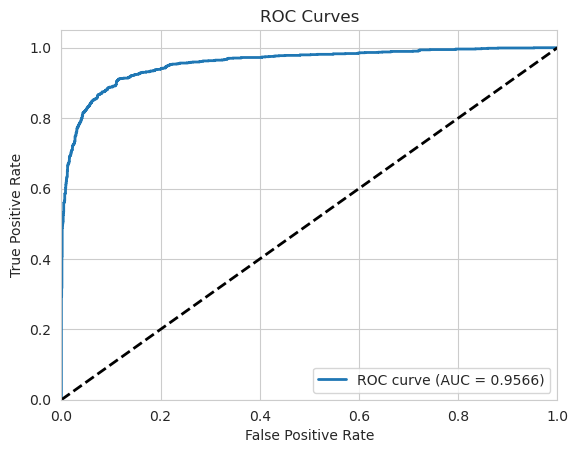

100%|██████████| 816/816 [00:26<00:00, 30.63it/s]


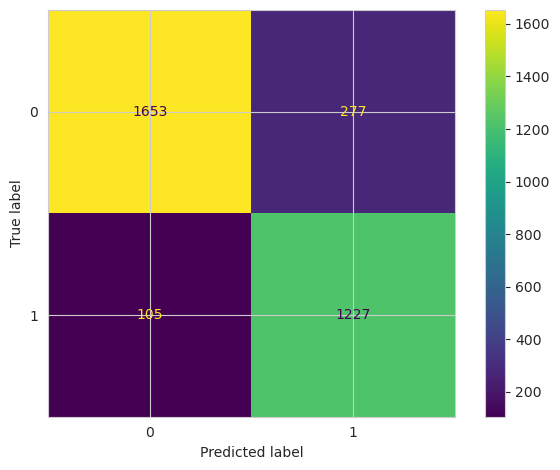

Saved features to train_features.csv
Saved features to test_features.csv
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -3.014979   5.435738  -1.401370   2.042252  -1.513048   1.937962   
1  -3.150948   5.523982  -2.044110   2.503558  -1.620541   2.261458   
2  -3.799756   5.449561   1.014948   0.610364  -2.090431   2.582901   
3  -2.972244   4.434703   0.581121   0.694778  -1.648330   2.114527   
4  -2.875355   3.886639   2.300841  -0.468490  -1.705193   1.902790   

   feature_6  feature_7  instance_label  patient_label  class_0  class_1  \
0   2.137218   1.460255               0              1        1        0   
1   1.825546   2.045120               0              1        1        0   
2   3.950232  -1.931630               0              1        1        0   
3   2.878913  -1.309271               0              1        1        0   
4   3.482225  -3.292421               0              1        1        0   

   class_2  class_3  class_4  class_5  bag_

In [30]:
if __name__ == "__main__":
    main(mode='train', use_cv=False, num_folds=5)

In [31]:
# import torch
# import torch.nn as nn
# import torchsummary
#
# class VGG(nn.Module):
#     def __init__(self, input_channels=3):
#         super(VGG, self).__init__()
#
#         self.features = nn.Sequential(
#             # Conv1
#             nn.Conv2d(input_channels, 16, kernel_size=5, padding=2),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#
#             # Conv2
#             nn.Conv2d(16, 32, kernel_size=3, padding=0),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout(0.3),
#
#             # Conv3
#             nn.Conv2d(32, 32, kernel_size=3, padding=0),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#
#             # Conv4
#             nn.Conv2d(32, 32, kernel_size=3, padding=2),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#
#             # Conv5
#             nn.Conv2d(32, 32, kernel_size=3, padding=0),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout(0.3),
#
#             # Conv6
#             nn.Conv2d(32, 32, kernel_size=3, padding=0),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout(0.3)
#         )
#
#         self.flatten = nn.Flatten()
#
#     def forward(self, x):
#         x = self.features(x)
#         x = self.flatten(x)
#         return x
#
# # Instantiate the model
# model = VGG(input_channels=1)
#
# # If you need to use the Glorot (Xavier) uniform initialization
# def init_weights(m):
#     if type(m) == nn.Conv2d:
#         torch.nn.init.xavier_uniform_(m.weight)
#
# model.apply(init_weights)
#
# # # Test the model with a sample input
# # input_tensor = torch.randn(1, 1, 512, 512)
# # output = model(input_tensor)
# # print(f"Output shape: {output.shape}")
#
# # # Print the model architecture
# model_info = torchsummary.summary(model, (1, 512, 512), device='cpu')
# print(model_info)

# Phase 2
## Pretrained Features

In [32]:
class PretrainedFeaturesDataset(Dataset):
    def __init__(self, data, num_classes):
        self.data = data
        self.num_classes = num_classes
        self.bag_ids = self.data['bag_id'].unique()
        self.grouped_data = {bag_id: self.data[self.data['bag_id'] == bag_id] for bag_id in self.bag_ids}

    def __len__(self):
        return len(self.bag_ids)

    def __getitem__(self, idx):
        bag_id = self.bag_ids[idx]
        bag_data = self.grouped_data[bag_id]

        # Extract features (all instances for this bag)
        features = torch.FloatTensor(bag_data.filter(like='feature_').values)

        # Extract instance labels (all instances for this bag)
        instance_labels = torch.LongTensor(bag_data['instance_label'].values)

        # Extract bag label (same for all instances in the bag)
        bag_label = torch.FloatTensor([bag_data['patient_label'].iloc[0]])

        # Extract bag multi-labels (same for all instances in the bag)
        bag_multi_labels = torch.FloatTensor(bag_data.filter(like='class_').iloc[0].values)

        return features, instance_labels, bag_label, bag_multi_labels

def custom_collate(batch, pad_size=28):
    # Separate the batch into individual components
    features, instance_labels, bag_labels, bag_multi_labels = zip(*batch)

    # Pad or truncate features and instance labels to fixed size
    features_padded = torch.stack([F.pad(f, (0, 0, 0, pad_size - f.size(0))) if f.size(0) < pad_size
                                   else f[:pad_size] for f in features])
    instance_labels_padded = torch.stack([F.pad(il, (0, pad_size - il.size(0)), value=-1) if il.size(0) < pad_size
                                          else il[:pad_size] for il in instance_labels])

    # Stack bag labels and bag multi labels (they should all be the same size)
    bag_labels = torch.stack(bag_labels)
    bag_multi_labels = torch.stack(bag_multi_labels)

    return features_padded, instance_labels_padded, bag_labels, bag_multi_labels

def create_pretrained_features_loader(data, num_classes, batch_size, shuffle=True, num_workers=4, drop_last=False, pad_size=28):
    dataset = PretrainedFeaturesDataset(data, num_classes)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
                      drop_last=drop_last, collate_fn=lambda x: custom_collate(x, pad_size=pad_size))

## Phase 2 Model

In [33]:
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.means import ZeroMean, ConstantMean
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

class PGLikelihood(gpytorch.likelihoods._OneDimensionalLikelihood):
    # contribution to Eqn (10) in Reference [1].
    def expected_log_prob(self, target, input, *args, **kwargs):
        mean, variance = input.mean, input.variance
        # Compute the expectation E[f_i^2]
        raw_second_moment = variance + mean.pow(2)

        # Translate targets to be -1, 1
        target = target.to(mean.dtype).mul(2.).sub(1.)

        # We detach the following variable since we do not want
        # to differentiate through the closed-form PG update.
        c = raw_second_moment.detach().sqrt()
        # Compute mean of PG auxiliary variable omega: 0.5 * Expectation[omega]
        # See Eqn (11) and Appendix A2 and A3 in Reference [1] for details.
        half_omega = 0.25 * torch.tanh(0.5 * c) / c

        # Expected log likelihood
        res = 0.5 * target * mean - half_omega * raw_second_moment
        # Sum over data points in mini-batch
        res = res.sum(dim=-1)

        return res

    # define the likelihood
    def forward(self, function_samples):
        return torch.distributions.Bernoulli(logits=function_samples)

    # define the marginal likelihood using Gauss Hermite quadrature
    def marginal(self, function_dist):
        prob_lambda = lambda function_samples: self.forward(function_samples).probs
        probs = self.quadrature(prob_lambda, function_dist)
        return torch.distributions.Bernoulli(probs=probs)


class SingletaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel_type='rbf', nu=0.5):
        """
        Args:
            inducing_points (torch.Tensor):
            kernel_type (str):
            nu (float):
        """
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(SingletaskGPModel, self).__init__(variational_strategy)

        # self.mean_module = gpytorch.means.ZeroMean()
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel_type == 'rbf':
            self.covar_module = ScaleKernel(RBFKernel())
        elif kernel_type == 'matern_kernel':
            self.covar_module = ScaleKernel(MaternKernel(nu=nu))
        else:
            raise ValueError("kernel_type must be either 'rbf' or 'matern_kernel'")

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.gate = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, num_instances, input_dim)
        attention_weights = self.attention(x)
        gate_weights = torch.sigmoid(self.gate(x))

        weights = attention_weights * gate_weights
        weights = F.softmax(weights, dim=1)

        return (x * weights).sum(dim=1), weights.squeeze(-1)

class MILAttentionLayer(nn.Module):
    """Implementation of the attention-based Deep MIL layer."""

    def __init__(
        self,
        input_dim,
        weight_params_dim,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        use_gated=False,
    ):
        super().__init__()

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        # Initialize weights
        self.v_weight_params = nn.Parameter(torch.Tensor(input_dim, weight_params_dim))
        self.w_weight_params = nn.Parameter(torch.Tensor(weight_params_dim, 1))

        if self.use_gated:
            self.u_weight_params = nn.Parameter(torch.Tensor(input_dim, weight_params_dim))

        # Initialize weights using the specified initializer
        if kernel_initializer == "glorot_uniform":
            nn.init.xavier_uniform_(self.v_weight_params)
            nn.init.xavier_uniform_(self.w_weight_params)
            if self.use_gated:
                nn.init.xavier_uniform_(self.u_weight_params)

        # Add regularization if specified
        self.kernel_regularizer = kernel_regularizer

    def compute_attention_scores(self, instance):
        original_instance = instance
        instance = torch.tanh(torch.matmul(instance, self.v_weight_params))

        if self.use_gated:
            instance = instance * torch.sigmoid(torch.matmul(original_instance, self.u_weight_params))

        return torch.matmul(instance, self.w_weight_params)

    def forward(self, x):
        attention_scores = self.compute_attention_scores(x)
        attention_weights = torch.softmax(attention_scores, dim=1)
        return torch.sum(x * attention_weights, dim=1)

    def regularization_loss(self):
        reg_loss = 0
        if self.kernel_regularizer:
            reg_loss += self.kernel_regularizer(self.v_weight_params)
            reg_loss += self.kernel_regularizer(self.w_weight_params)
            if self.use_gated:
                reg_loss += self.kernel_regularizer(self.u_weight_params)
        return reg_loss

# Define the CNN_Att Model
class CNN_Att(nn.Module):
    def __init__(self, feature_dim, hidden_dim, output_dim, num_ind=50):
        super(CNN_Att, self).__init__()
        self.attention_layer = AttentionLayer(feature_dim, hidden_dim)
        self.att_layer = MILAttentionLayer(feature_dim, hidden_dim)
        self.fc = nn.Linear(feature_dim + 1, output_dim)  # Fully connected layer
        self.dropout = nn.Dropout(0.25)

        inducing_points = torch.rand(num_ind, 1) # Random
        self.gp_layer = SingletaskGPModel(inducing_points)
        with torch.inference_mode():
            self.gp_layer.covar_module.base_kernel.lengthscale = torch.tensor([2.0])
            self.gp_layer.covar_module.outputscale = torch.tensor([0.5])

        self.fc_gp = nn.Linear(feature_dim, 1)

    def forward(self, x):
        # x shape: (batch_size, num_instances, feature_dim)
        # attended_features, attention_weights = self.attention_layer(x)
        attended_features = self.att_layer(x)
        attended_features = self.dropout(attended_features)
        x = self.fc_gp(attended_features)
        gp_output = self.gp_layer(x)
        output = self.fc(torch.cat([attended_features, gp_output.mean.unsqueeze(-1)], dim=-1))
        output = output.squeeze(1)
        return output, gp_output, _

## Training and Evaluation Functions

In [34]:
# Training function
def train(model, dataloader, optimizer, criterion, device, likelihood, var_optimizer, mlls):
    model.train()
    likelihood.train()
    epoch_loss = 0
    all_labels = []
    all_preds = []
    with gpytorch.settings.num_likelihood_samples(100):
        # for features, instance_labels, patient_label, patient_multi_label in dataloader:
        for features, patient_label in dataloader:
            features, patient_label = features.to(device), patient_label.to(device)

            optimizer.zero_grad()
            var_optimizer.zero_grad()

            # Forward pass
            predictions, gp_output, _ = model(features)  # predictions shape: (batch_size, 1)
            loss = -mlls(gp_output, patient_label) * 0.5 + criterion(predictions, patient_label) * 0.5
            # loss = -mlls(gp_output, patient_label)
            # loss = criterion(predictions, patient_label)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            var_optimizer.step()

            epoch_loss += loss.item()
            # preds = (torch.sigmoid(predictions) > 0.5).float()
            preds = likelihood(gp_output).probs.ge(THRESHOLD).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(patient_label.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    average = 'weighted'
    precision = precision_score(all_labels, all_preds, average=average)
    recall = recall_score(all_labels, all_preds, average=average)
    f1 = f1_score(all_labels, all_preds, average=average)

    return epoch_loss / len(dataloader), accuracy, precision, recall, f1


# Evaluation function
def evaluate(model, dataloader, criterion, device, likelihood, mlls):
    model.eval()
    likelihood.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    all_scores = []
    with torch.no_grad():
        # for features, instance_labels, patient_label, patient_multi_label in dataloader:
        for features, patient_label in dataloader:
            features, patient_label = features.to(device), patient_label.to(device)

            # Forward pass
            predictions, gp_output, _ = model(features)  # predictions shape: (batch_size, 1)
            loss = -mlls(gp_output, patient_label) * 0.5 + criterion(predictions, patient_label) * 0.5
            # loss = -mlls(gp_output, patient_label)
            # loss = criterion(predictions, patient_label)

            epoch_loss += loss.item()
            all_labels.extend(patient_label.cpu().numpy())
            probs = likelihood(gp_output).probs
            # probs = torch.sigmoid(predictions)
            preds = (probs >= THRESHOLD).float()
            all_preds.extend((preds >= THRESHOLD).cpu().numpy())
            all_scores.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    average = 'weighted'
    precision = precision_score(all_labels, all_preds, average=average)
    recall = recall_score(all_labels, all_preds, average=average)
    f1 = f1_score(all_labels, all_preds, average=average)
    cohen_kappa = cohen_kappa_score(all_labels, all_preds)

    return epoch_loss / len(dataloader), accuracy, precision, recall, f1, cohen_kappa, all_labels, all_preds, all_scores

# Function to plot ROC AUC curve
def plot_roc_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

def plot_pr_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_pr = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', label=f'AUC-PR = {auc_pr:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_scores):
    y_pred = []
    for score in y_scores:
        if score >= THRESHOLD:
            y_pred.append(1)
        else:
            y_pred.append(0)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Main function

In [35]:
# Load data from CSV
def load_data(csv_file, num_instances=28, test_size=0.2, random_state=42):
    df = pd.read_csv(csv_file)

    # Group features by bag_name
    grouped = df.groupby('bag_id')

    # Prepare feature lists and label lists
    feature_list = []
    label_list = []

    for bag_name, group in grouped:
        # Extract features for the current bag
        feature_cols = [f'feature_{i}' for i in range(8)]
        features = group[feature_cols].values

        # Pad with zeros if the number of instances is less than num_instances
        if len(features) < num_instances:
            padding_size = num_instances - len(features)
            padding = np.zeros((padding_size, 8))
            features = np.vstack((features, padding))  # Vertically stack features and padding

        # Truncate if the number of instances is greater than num_instances (shouldn't happen, but good to be safe)
        elif len(features) > num_instances:
            features = features[:num_instances]

        feature_list.append(features)

        # Get the bag label for the current bag
        bag_label = group['patient_label'].values[0]
        label_list.append(bag_label)

    # Convert to numpy arrays
    X = np.array(feature_list)
    y = np.array(label_list)

    return X, y

# Define a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

Positive weights: 1.0
Starting training...
Epoch 1/100: Train: Loss=0.4544, Acc=0.6559, Precision=0.6576, Recall=0.6559, F1=0.6223
Val: Loss=0.3312, Acc=0.6991, Precision=0.6949, Recall=0.6991, F1=0.6924 

Epoch 2/100: Train: Loss=0.3036, Acc=0.7207, Precision=0.7175, Recall=0.7207, F1=0.7161
Val: Loss=0.2672, Acc=0.7331, Precision=0.7304, Recall=0.7331, F1=0.7291 

Epoch 3/100: Train: Loss=0.2496, Acc=0.7502, Precision=0.7480, Recall=0.7502, F1=0.7476
Val: Loss=0.2247, Acc=0.7515, Precision=0.7493, Recall=0.7515, F1=0.7486 

Epoch 4/100: Train: Loss=0.2114, Acc=0.7722, Precision=0.7705, Recall=0.7722, F1=0.7698
Val: Loss=0.1894, Acc=0.7748, Precision=0.7732, Recall=0.7748, F1=0.7729 

Epoch 5/100: Train: Loss=0.1698, Acc=0.7945, Precision=0.7933, Recall=0.7945, F1=0.7928
Val: Loss=0.1443, Acc=0.7954, Precision=0.7941, Recall=0.7954, F1=0.7937 

Epoch 6/100: Train: Loss=0.1155, Acc=0.8247, Precision=0.8240, Recall=0.8247, F1=0.8232
Val: Loss=0.0840, Acc=0.8328, Precision=0.8322, Recall

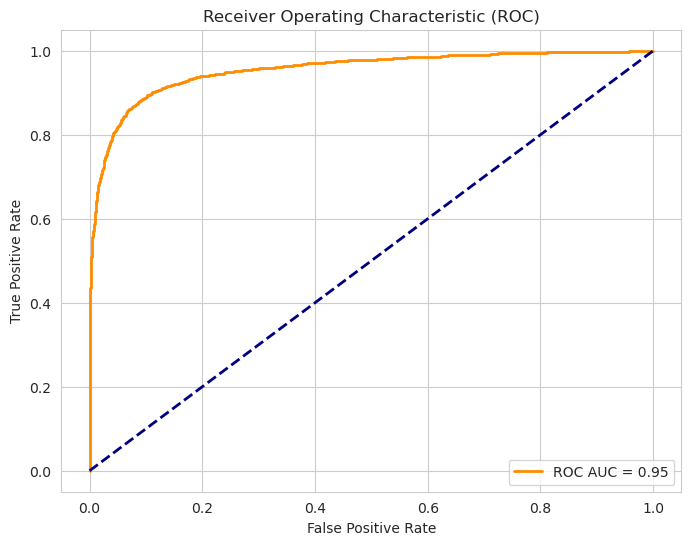

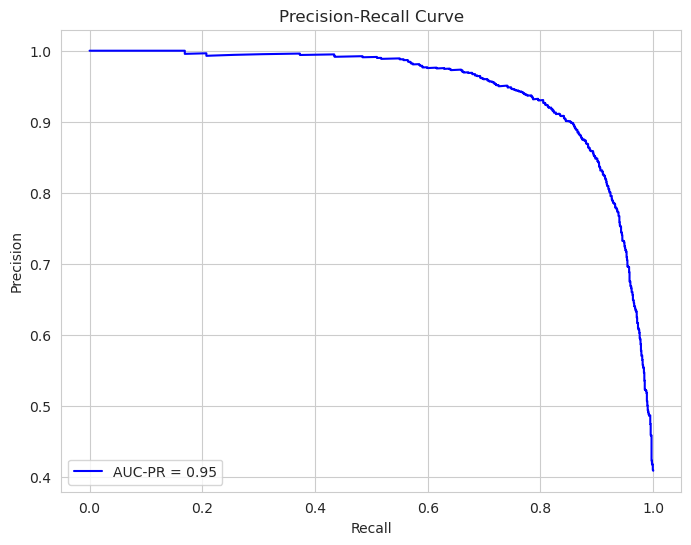

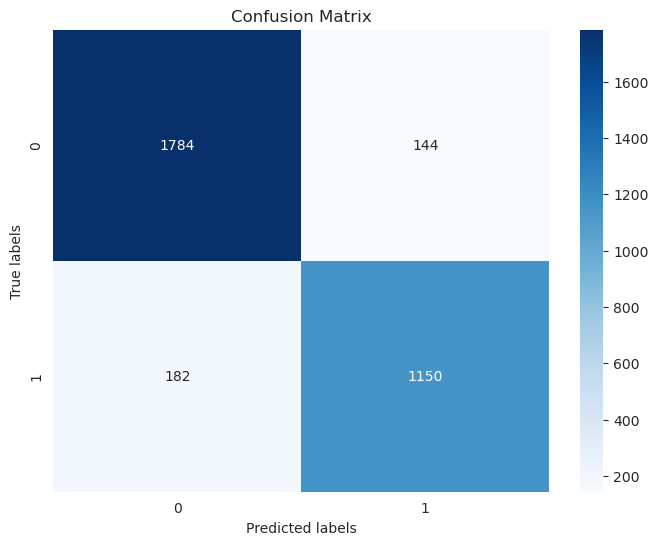

In [36]:
# Main function
def main(hidden_dim=64, learning_rate=0.00005, batch_size=16, num_epochs=200, num_instances=MAX_SLICES):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    X_train, y_train = load_data('train_features.csv', num_instances=num_instances)
    X_test, y_test = load_data('test_features.csv', num_instances=num_instances)

    # Create Datasets and DataLoaders
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, optimizer, and loss function
    output_dim = 1
    features_dim = 8
    model = CNN_Att(features_dim, hidden_dim, output_dim, num_ind=50).to(device)
    likelihood = PGLikelihood().to(device)

    mlls = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(train_loader))
    variational_ngd_optim = gpytorch.optim.NGD(model.gp_layer.variational_parameters(), num_data=len(train_loader), lr=0.01)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    # pos_weights = torch.tensor([np.sum(y_train == 0) / np.sum(y_train == 1)], dtype=torch.float32).to(device)
    POS_WEIGHT = 1.0
    pos_weights = torch.tensor([POS_WEIGHT], dtype=torch.float32).to(device)
    print(f'Positive weights: {pos_weights.item()}')
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)  # Binary cross-entropy loss with logits

    # Training loop
    print("Starting training...")
    for epoch in range(num_epochs):
        train_loss, train_acc,  train_precision, train_recall, train_f1 = train(model, train_loader, optimizer, criterion, device, likelihood, variational_ngd_optim, mlls)
        val_loss, val_acc, val_precision, val_recall, val_f1, _, _, _, _ = evaluate(model, test_loader, criterion, device, likelihood, mlls)

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, Precision={train_precision:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}')
        print(f'Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}, Precision={val_precision:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f} \n')

    # Plot ROC AUC curve
    test_loss, test_acc, test_precision, test_recall, test_f1, test_co_kappa, test_labels, test_preds, test_scores = evaluate(model, test_loader, criterion, device, likelihood, mlls)
    print(f'Test: Loss={test_loss:.4f}, Acc={test_acc:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1={test_f1:.4f}, Cohen Kappa={test_co_kappa:.4f}')
    plot_roc_auc(test_labels, test_scores)
    plot_pr_curve(test_labels, test_scores)
    plot_confusion_matrix(test_labels, test_scores)

if __name__ == "__main__":
    def seed_everything(seed=26):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    seed_everything()

    main(hidden_dim=64, learning_rate=0.0001, batch_size=32, num_epochs=100, num_instances=MAX_SLICES)

# Results
